### Import the Necessary Libraries :

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [8]:
data = pd.read_csv('sample_data/Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Data Info :

In [9]:
data.shape

(200, 5)

In [10]:
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


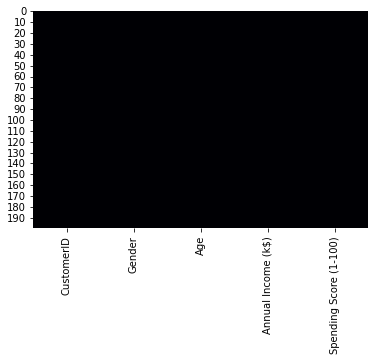

In [12]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

- **No null values** present in the data!

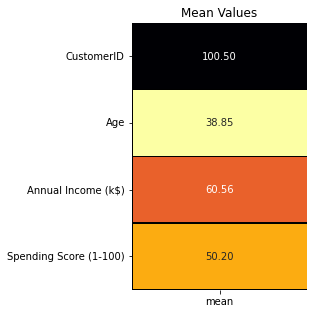

In [13]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))

plt.subplot(1,1,1)
sns.heatmap(data.describe().T[['mean']],cmap = 'inferno_r',annot = True,fmt = '.2f',linecolor = 'black',linewidths = 0.4,cbar = False);
plt.title('Mean Values');

fig.tight_layout(pad = 3)

- Average customer **Age** in the dataset is in the late 30s i.e **38.85**. 
- Average **Annual Income (k\\$)** of the customers is **60.56** i.e just short of the 2018 median income of USA citizen, 63k$.
- **Spending Score (1-100)** average of the mall customer is in the center with **50.20**.

# <center>Exploratory Data Analysis</center>

### Dividing features into Numerical and Categorical :

In [14]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Gender
Numerical Features : CustomerID Age Annual Income (k$) Spending Score (1-100)


- Here, categorical features are defined if the the attribute has less than 6 unique elements else it is a numerical feature.
- Typical approach for this division of features can also be based on the datatypes of the elements of the respective attribute.

**Eg :** datatype = integer, attribute = numerical feature ; datatype = string, attribute = categorical feature

- For this dataset, as the number of features are less, we can check the dataset manually as well.

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Gender'] = le.fit_transform(df1['Gender'])

print('Label Encoder Transformation')
print(df1['Gender'].unique(),' = ',le.inverse_transform(df1['Gender'].unique()))

Label Encoder Transformation
[1 0]  =  ['Male' 'Female']


- Creating a deep copy of the orginal dataset and label encoding the text data of **Gender**.
- Modifications in the original dataset will not be highlighted in this deep copy.
- Hence, we use this deep copy of dataset that has **Gender** converted into numerical values for visualization & modeling purposes.

### Distribution of Categorical and Numerical Features :

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/loca

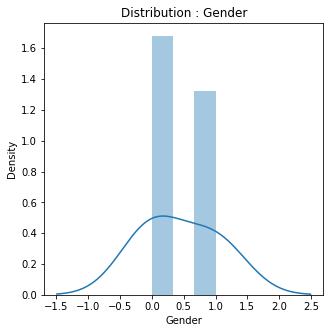

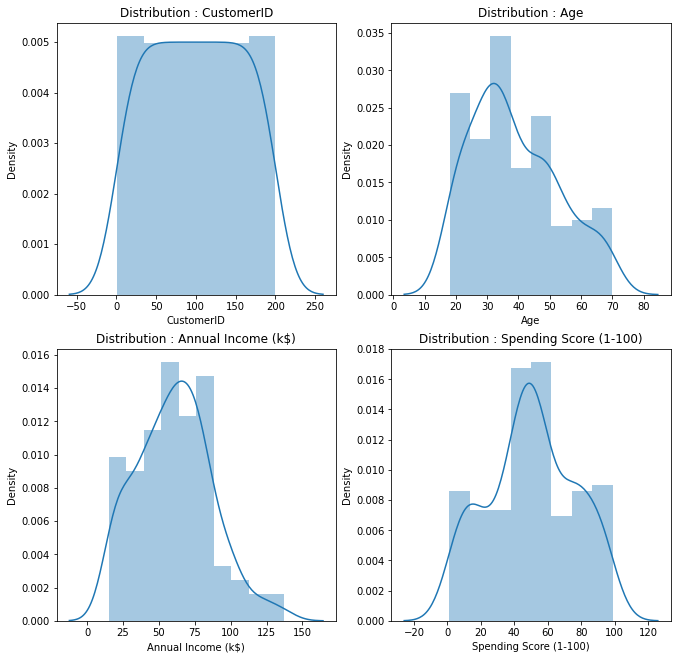

In [16]:
fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))
for i in range(len(categorical_features)):
    plt.subplot(1,1,i+1)
    sns.distplot(df1[categorical_features[i]],kde_kws = {'bw' : 1});
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)
    
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (11,11))
for i in range(len(numerical_features)):
    plt.subplot(2,2,i+1)
    sns.distplot(data[numerical_features[i]],)
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

- **Gender**, the only categorical feature, data displays a **normally distribution**.
- Distribution of **Age** and **Annual Income (k\\$)** is **positively or righly skewed**.
- **Spending Score (1-100)** data distribution is similar to the **Head and Shoulder** pattern observed in stock charts. 
- It displays a stock's price rising to a peak and then declines back to the base of the prior up-move. Something similar can be observed with the **2 shoulders** forming around the values **20 & 80** with **head** being centered in between **40 - 60**.
- We will drop the **CustomerID** feature as it is just a number that is tagged to a customer.

In [17]:
numerical_features.remove('CustomerID')

### Categorical Features :

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


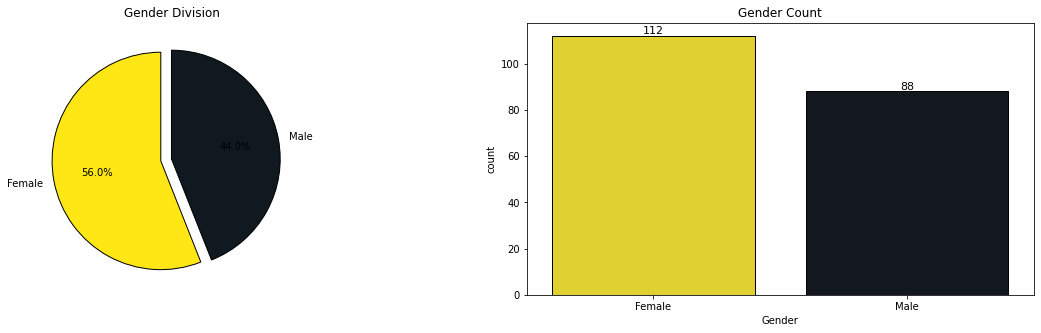

In [18]:
l = list(data['Gender'].value_counts())
circle = [l[0] / len(l) * 100, l[1] / len(l) * 100]
colors = ['#FEE715','#101820']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))

plt.subplot(1,2,1)
plt.pie(circle,labels = ['Female','Male'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Gender Division');

plt.subplot(1,2,2)
ax = sns.countplot('Gender',data = df1,palette = colors,edgecolor = 'black');
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.75, rect.get_height(), horizontalalignment='center', fontsize = 11)
plt.title('Gender Count')
ax.set_xticklabels(['Female','Male'])

plt.show()

- For the above dataset, **female** customers just edge out the **male** customers. 

### Numerical Features vs Categorical Features :

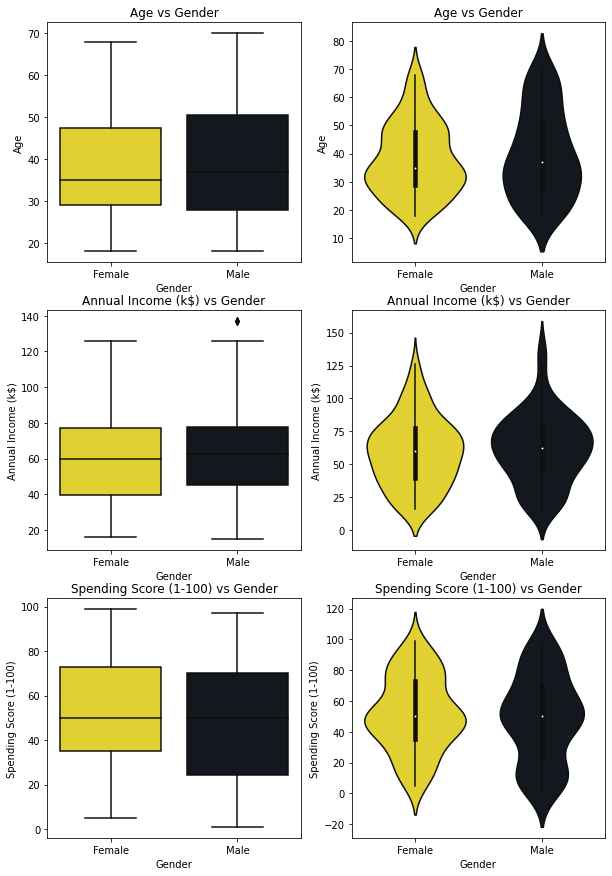

In [19]:
fig = plt.subplots(nrows = 3,ncols = 2,figsize = (10,15))
for i in range(len(numerical_features)):
    plt.subplot(3,2, (i * 2)  + 1)
    ax = sns.boxplot(x = 'Gender',y = numerical_features[i],palette = colors,data = df1)
    ax.set_xticklabels(['Female','Male'])
    title = numerical_features[i] + ' vs Gender'
    plt.title(title)
    
    plt.subplot(3,2,(i * 2) + 2)
    ax = sns.violinplot(x = 'Gender',y = numerical_features[i],palette = colors,data = df1)
    ax.set_xticklabels(['Female','Male'])
    title = numerical_features[i] + ' vs Gender'
    plt.title(title)

- **Age** range of **female** customers is from **30 to just below 50** whereas **male** customers **Age** ranges from **just below 30 to 50**. 
- For both **Genders**, a bulge at the age of **30 - 35** can be observed. Median **Age** of **male** is slightly more than those of **female**.
- For **Annual Income (k\\$)**, **female** customer's income starts from **40k** whereas **male** customer's is above this value. 
- Median **Annual Income (k\\$)** for both **Genders** is near about **60k**. **Annual Income (k\\$)** of **male** customers tapers very sharply at the apex with some outliers as compared to **female** customers.
- Median **Spending Score (1-100)** of both **Genders** is same despite having different starting points of **just below 40** & **just above 20** for **female** and **male** customers respectively.
- Both the **Genders** display a strong bulge at the median value especially **female** customers. However, **male** customers display a small but significant bulge in the range of **0 - 20** as well.

### Numerical Features vs Numerical Features w.r.t Categorical Feature :

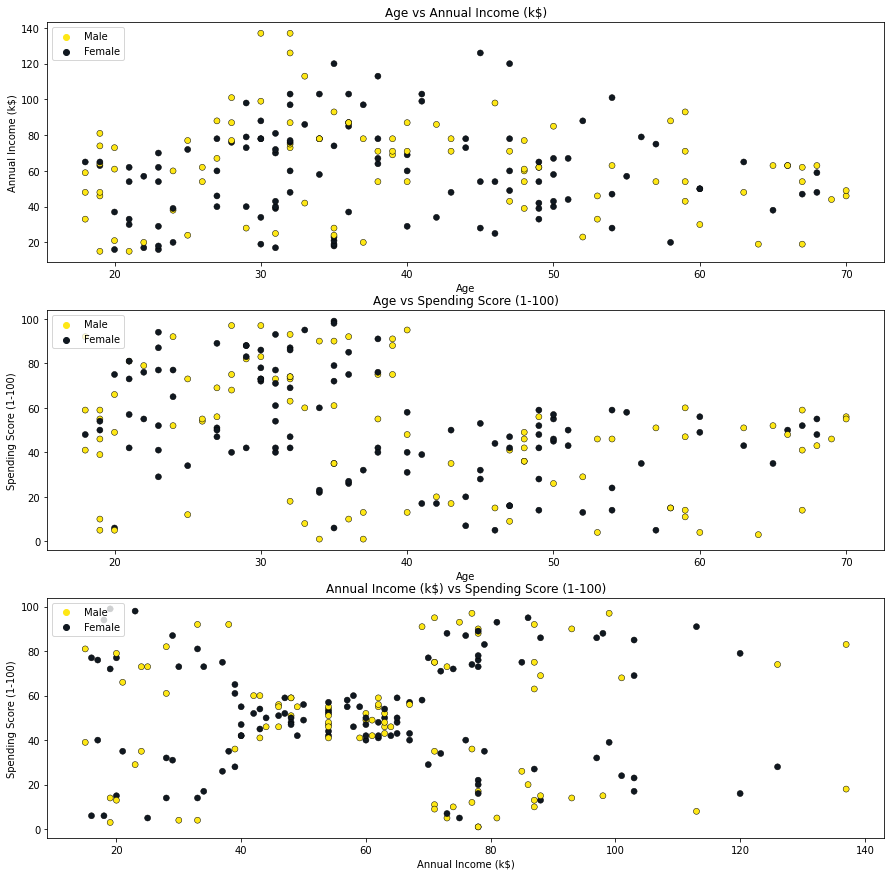

In [20]:
a = 0
fig,ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
for i in range(len(numerical_features) - 1):
    for j in range(len(numerical_features)):
        if i != j and j > i:
            a += 1
            plt.subplot(3,1,a)
            sns.scatterplot(x = numerical_features[i],y = numerical_features[j],data = data,
                            hue = 'Gender',palette = colors,edgecolor = 'black');
            plt.legend(loc = 'upper left',)
            title = numerical_features[i] + ' vs ' + numerical_features[j]
            plt.title(title)

- **Annual Income (k\\$)** datapoints are present throughout the all the **Age** values, **Gender** does not provide any significant information. 
- For **Spending Score (1-100)**, it can be clearly observed that **Age** ranges **20 - 30** display very high spending habits. 
- **Age** group **30 - 40** highlights both the extremes of spending habits in the customer. **40 - 70 Age** group customer displays the other end of spending habits with low values.    
- From the **Annual Income (k\\$) vs Spending Score (1-100)**, distinct 5 groups can be observed. For **Annual Income (k\\$)** values between **0 - 40**, data highlights 2 groups of customers with **Spending Score (1-100)** between **0 - 40** and **60 - 100**.
- After displaying this 1 extreme, data highlights the middle group of customers that have an **Annual Income (k\\$)** between **40 - 70k** and **Spending Score (1-100)** between **40 - 60**.
- **Annual Income (k\\$)** values between **70 - 140k** define the other extreme that is divided into 2 groups based on **Spending Score (1-100)** values of **0 - 40** and **60 - 100**.

# <center>Summary of EDA</center>

- For the above mall data, **female** customers are more than **male** customers. **Gender** data is pretty much evenly distributed w.r.t other features.
- Mall customers can be divided by their **Age** groups : 
    - **20 - 30** 
    - **30 - 40**
    - **40 - 70**. 
- Median **Annual Income (k\\$)** of both the **genders** is about **60k**. It displays 3 groups of values : 
    - **0 - 40k** 
    - **40 - 70k**
    - **70 - 140k**.
- **Spending Score (1-100)** of **female** is higher than **male** customers. It can also divide the customers into 3 groups :
    - **0 - 40**
    - **40 - 60**
    - **60 - 100**
- Using the combination of the above values, **Mall Customers** can be segmented and thus resulting in specific catering of them. 

# <center>Feature Engineering</center>

### Correlation Matrix :

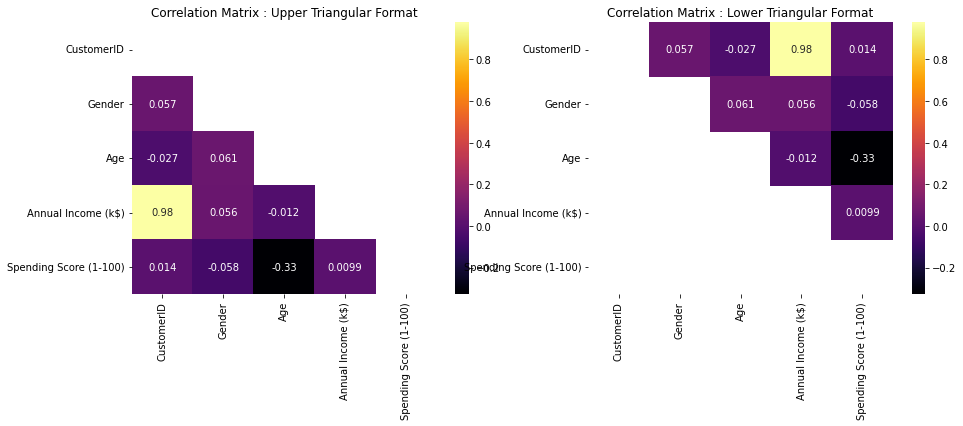

In [21]:
ut = np.triu(df1.corr())
lt = np.tril(df1.corr())

fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(df1.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

plt.subplot(1,2,2)
sns.heatmap(df1.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = lt);
plt.title('Correlation Matrix : Lower Triangular Format');

df1.drop(columns = 'CustomerID',inplace = True)

- Both the matrix displayed are same! It is only done for visualization purpose. This trick can be used when the dataset has too many features to look into! 
- **CustomerID** displays a very high positive correlation with **Annual Income (k\\$)** as the customers are arranged in ascending order according to their **Annual Income (k\\$)**. We are not going to include **CustomerID** for modeling purpose.
- **Gender** does not display any relation with other features. It is pretty much neutral with all the values sticking to 0.
- **Spending Score (1-100)** and **Age** display a negative correlation i.e if value of one feature increases, then another feature's value decreases and vice-versa is true!
- This information is gained from the **EDA** section the correlation matrix values further back the evidence. 
- We will now move to the modeling section by creating combinations of these features and finding different ways in which the mall customers can be segmented!

### Data Scaling :

- Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Thus, it becomes necessary to scale the data.

- We have 2 options for data scaling : 
    
    1) **Normalization** 
    
    2) **Standardization**. 


- As most of the algorithms assume the data to be normally (Gaussian) distributed, **Normalization** is done for features that does not display a normal distribution and **standardization** is carried out for features that are normally distributed but the range of values is huge or small as compared to other features.

- For the above dataset, we have carried out **Normalization** for 3 features : **Age**, **Annual Income (k\\$)** and **Spending Score (1-100)**. **Gender** feature is left untouched.

In [22]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

# Label Encoding 
df2 = df1.copy(deep = True)

# Normalization
df2['Age'] = mms.fit_transform(df2[['Age']])
df2['Annual Income (k$)'] = mms.fit_transform(df2[['Annual Income (k$)']])
df2['Spending Score (1-100)'] = mms.fit_transform(df2[['Spending Score (1-100)']])

- In order to highlight the difference between performance of the models when trained on original dataset and normalized dataset, we create a copy of the original dataset and apply the normalization transformation on it!

**We will now move to the modeling section!**

# <center>Modeling</center>

- **Unsupervised Learning** : It is a problem where the target variable / feature is unknown. **Unsupervised Learning** problems widely occur in medical domain where mutliple readings are taken and the underlying diseases are unknown. 
- Thus, searching for patterns by using visualization techniques provides us with some underlying insight that cannot be understood by staring into the tabular data.
- However, when the size of the datasets becomes huge with too many features, data visualization can be a tedious task to execute. Hence, we move towards **K-Means Clustering** algorithm which **does not support categorical features**. 
- It is the most preferred algorithm for dealing with **Unsupervised Learning** that does the job of finding clusters / groups in data but with a mathematical approach :
    - Selects 2 (assume k = 2) centroids randomly.
    - Distance between the centroids and all the data points are calculated.
    - If the data point is closer to one of the centroids, then it gets labelled as that centroid and vice-versa.
    - For the 2 clusters formed, average value of the data points, grouped with either of the centroid, is calculated and these average values are then defined as the new clusters.
    - This process repeats itself untill both centroids converge to fixed points.
- **k hyperparameter** : It defines the number of clusters or groups the data is to be divided into. For the selection of values of **k**, we use 2 statistical tests :
    - **Elbow Method** : It is a method that plots the sum of squared error for a range of values of **k**. If this plot looks like an arm, then **k** the value that resembles an **elbow** is selected. From this **elbow** value, sum of squared values (inertia) starts decreasing in a linear fashion and thus is considered as an optimal value.
    - **Silhouette Score Method** : It is a method that evaluates the quality of clusters in terms of how well data points are clustered with other data points that are similar to each other. This score is calculated using the distance formula and the **k** value with highest score is selected for modeling.
    
**We will now create models by training them on the combination of the features selected from the above tests and visualize as well.**

In [23]:
# Dropping categorical feature 
df1.drop(columns = 'Gender',inplace = True)
df2.drop(columns = 'Gender',inplace = True)

### <center>Age - Annual Income (k\$)</center>

In [24]:
m1 = df1[['Age','Annual Income (k$)']].values # Original Dataset
m2 = df2[['Age','Annual Income (k$)']].values # Normalized Dataset

### Original Dataset :

#### Elbow Method & Silhouette Score Method :

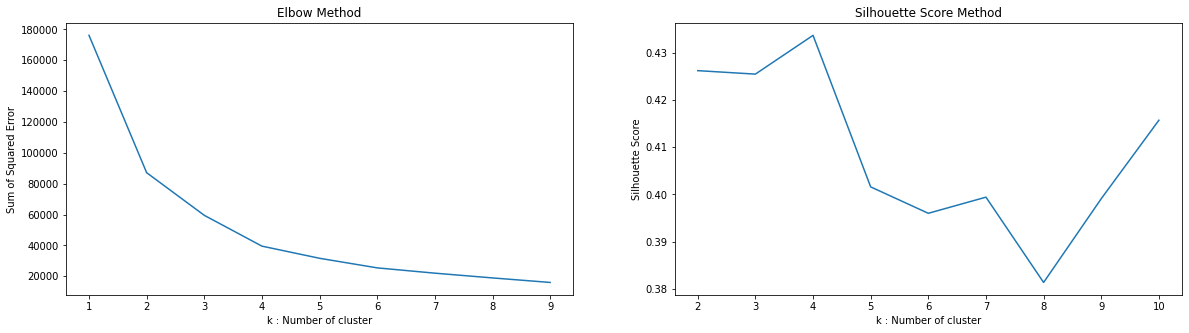

In [25]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m1)
    labels = kmeans.labels_
    sil.append(silhouette_score(m1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 4**

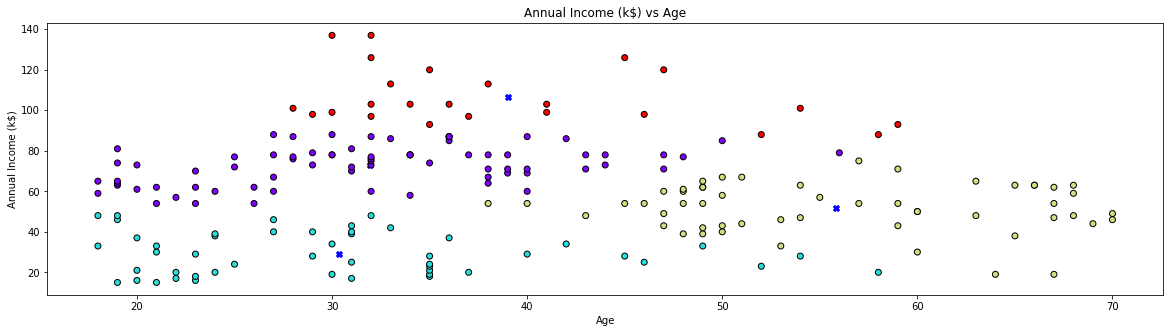

In [26]:
model = KMeans(n_clusters = 4,max_iter = 1000)
model.fit(m1)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

plt.figure(figsize = (20,5))
plt.scatter(centroids[:,0],centroids[:,1], marker = "X", color = 'b')
plt.scatter(x = 'Age',y = 'Annual Income (k$)',c = labels,cmap = 'rainbow',data = df1,edgecolor = 'black');
plt.title('Annual Income (k$) vs Age')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show();

### Normalized Dataset :

#### Elbow Method & Silhouette Score Method :

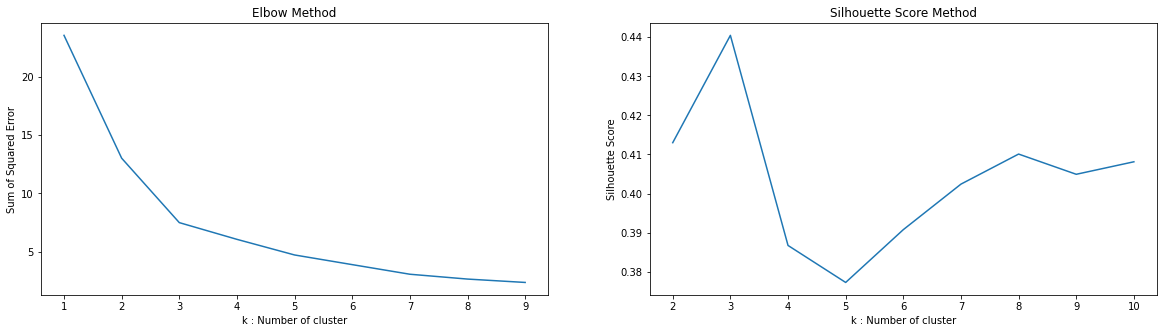

In [27]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m2)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m2)
    labels = kmeans.labels_
    sil.append(silhouette_score(m2, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 3**

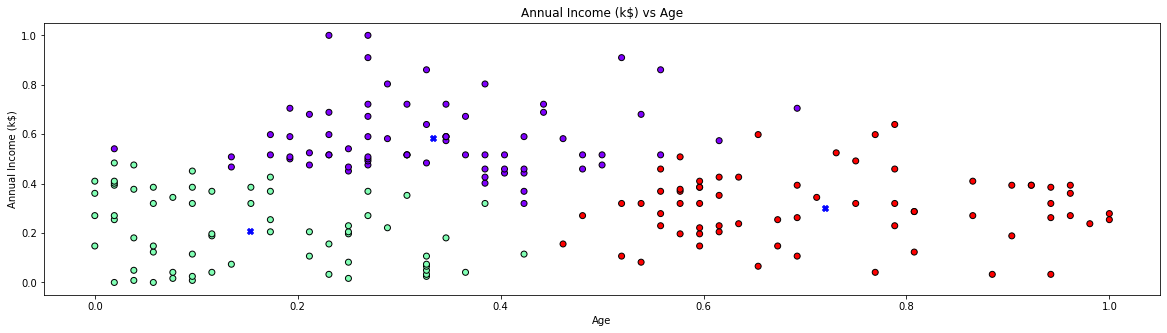

In [28]:
model = KMeans(n_clusters = 3,max_iter = 1000)
model.fit(m2)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

plt.figure(figsize = (20,5))
plt.scatter(centroids[:,0],centroids[:,1], marker = "X", color = 'b')
plt.scatter(x = 'Age',y = 'Annual Income (k$)',c = labels,cmap = 'rainbow',data = df2,edgecolor = 'black');
plt.title('Annual Income (k$) vs Age')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show();

### <center>Age - Spending Score (1-100)</center>

In [29]:
m1 = df1[['Age','Spending Score (1-100)']].values # Original Dataset
m2 = df2[['Age','Spending Score (1-100)']].values # Normalized Dataset

### Original Dataset :

#### Elbow Method & Silhouette Score Method :

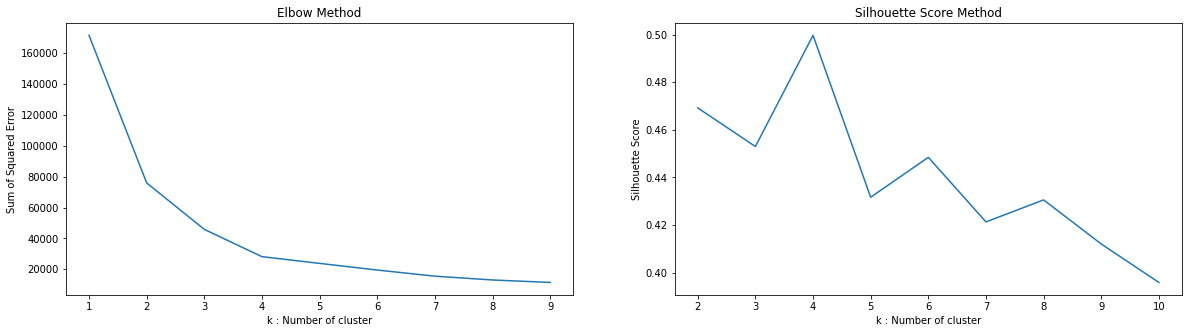

In [30]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m1)
    labels = kmeans.labels_
    sil.append(silhouette_score(m1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 4**

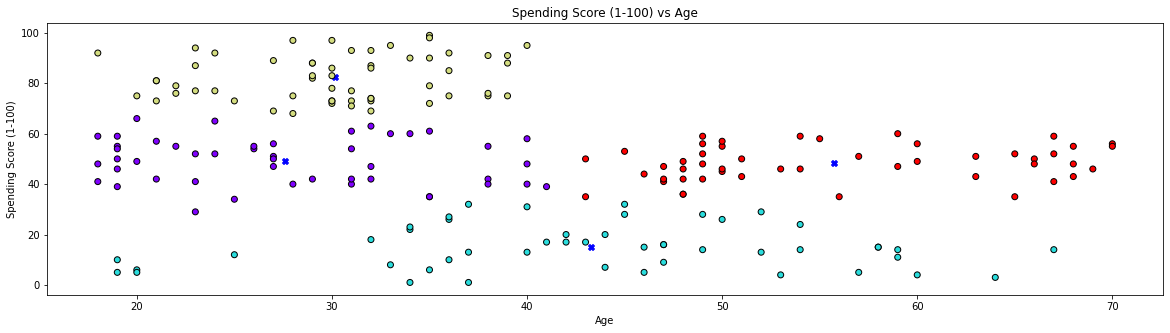

In [31]:
model = KMeans(n_clusters = 4,max_iter = 1000)
model.fit(m1)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

plt.figure(figsize = (20,5))
plt.scatter(centroids[:,0],centroids[:,1], marker = "X", color = 'b')
plt.scatter(x = 'Age',y = 'Spending Score (1-100)',c = labels,cmap = 'rainbow',data = df1,edgecolor = 'black');
plt.title('Spending Score (1-100) vs Age')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show();

### Normalized Dataset :

#### Elbow Method & Silhouette Score Method :

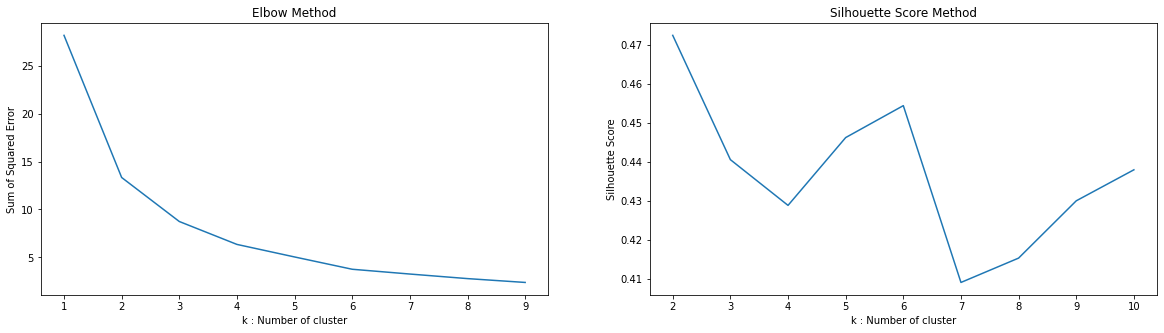

In [32]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m2)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m2)
    labels = kmeans.labels_
    sil.append(silhouette_score(m2, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 6**

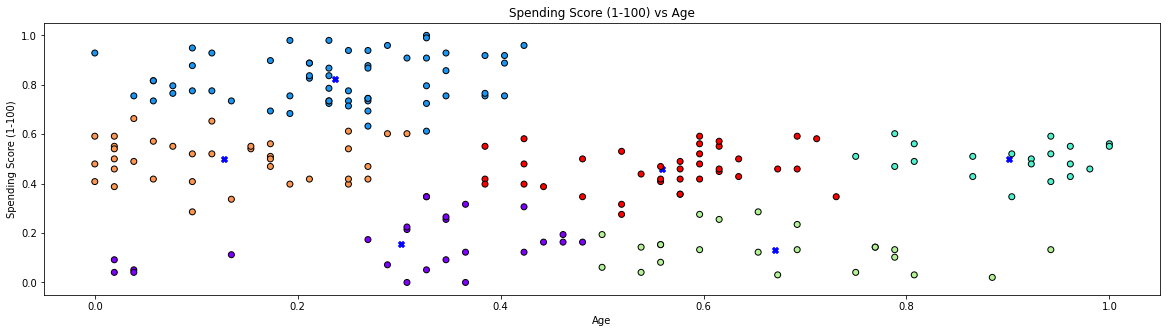

In [33]:
model = KMeans(n_clusters = 6,max_iter = 1000)
model.fit(m2)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

plt.figure(figsize = (20,5))
plt.scatter(centroids[:,0],centroids[:,1], marker = "X", color = 'b')
plt.scatter(x = 'Age',y = 'Spending Score (1-100)',c = labels,cmap = 'rainbow',data = df2,edgecolor = 'black');
plt.title('Spending Score (1-100) vs Age')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show();

### <center>Annual Income (k\$) - Spending Score (1-100)</center>

In [34]:
m1 = df1[['Annual Income (k$)', 'Spending Score (1-100)']].values # Original Dataset
m2 = df2[['Annual Income (k$)', 'Spending Score (1-100)']].values # Normalized Dataset

### Original Dataset :

#### Elbow Method & Silhouette Score Method :

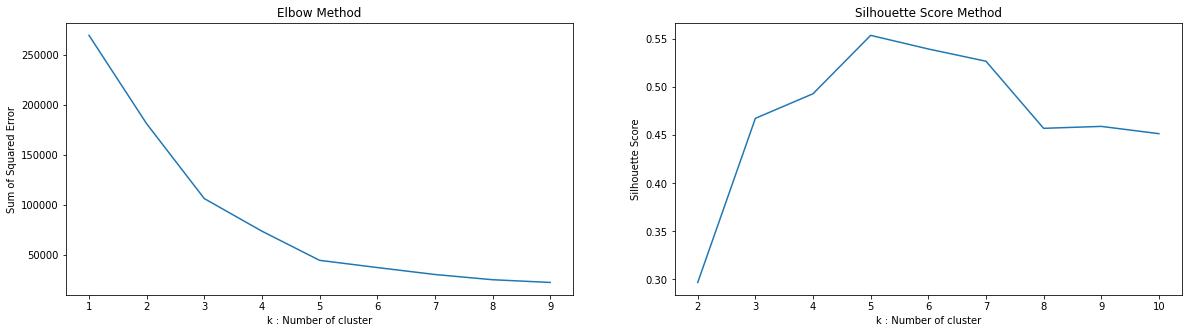

In [35]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m1)
    labels = kmeans.labels_
    sil.append(silhouette_score(m1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 5**

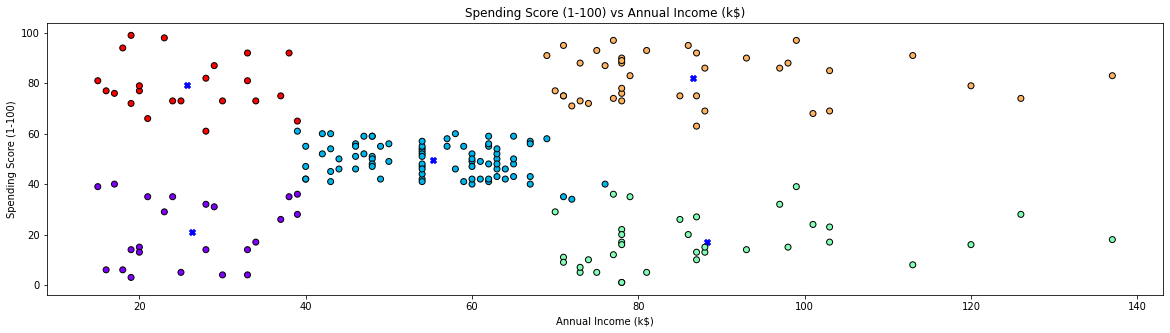

In [36]:
model = KMeans(n_clusters = 5,max_iter = 1000)
model.fit(m1)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

plt.figure(figsize = (20,5))
plt.scatter(centroids[:,0],centroids[:,1], marker = "X", color = 'b')
plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)',c = labels,cmap = 'rainbow',data = df1,edgecolor = 'black');
plt.title('Spending Score (1-100) vs Annual Income (k$)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show();

### Normalized Dataset :

#### Elbow Method & Silhouette Score Method :

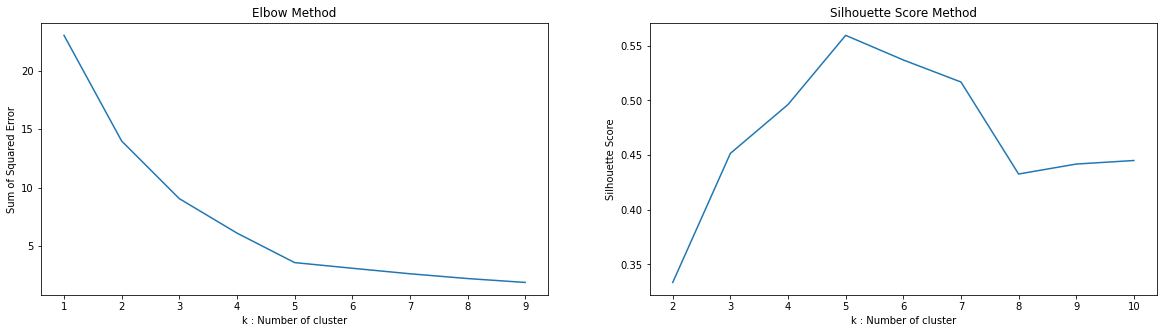

In [37]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m2)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m2)
    labels = kmeans.labels_
    sil.append(silhouette_score(m2, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 5**

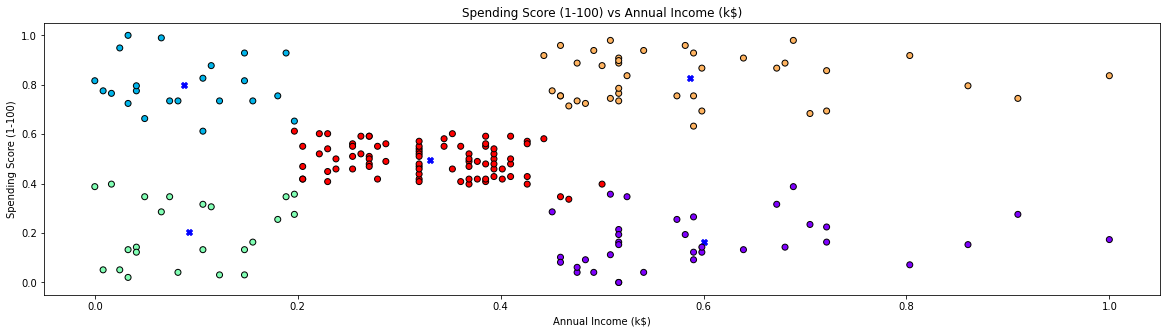

In [38]:
model = KMeans(n_clusters = 5,max_iter = 1000)
model.fit(m2)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

plt.figure(figsize = (20,5))
plt.scatter(centroids[:,0],centroids[:,1], marker = "X", color = 'b')
plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)',c = labels,cmap = 'rainbow',data = df2,edgecolor = 'black');
plt.title('Spending Score (1-100) vs Annual Income (k$)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show();

### <center>Age - Annual Income (k\$) - Spending Score (1-100)</center>

In [39]:
m1 = df1[['Age','Annual Income (k$)','Spending Score (1-100)']].values # Original Dataset
m2 = df2[['Age','Annual Income (k$)','Spending Score (1-100)']].values # Normalized Dataset

### Original Dataset :

#### Elbow Method & Silhouette Score Method :

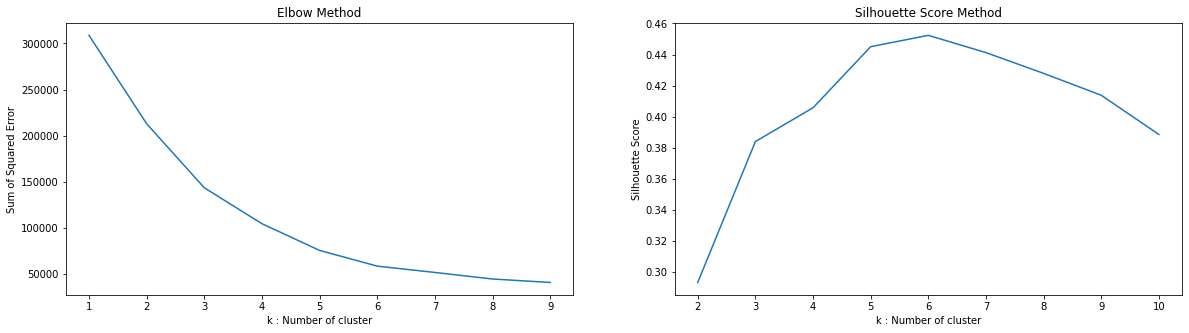

In [40]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m1)
    labels = kmeans.labels_
    sil.append(silhouette_score(m1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 6**

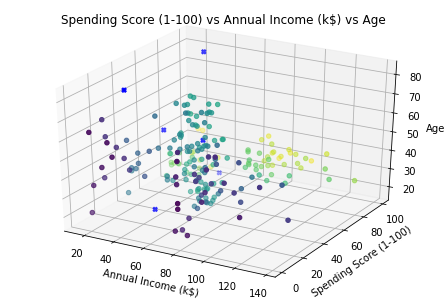

In [41]:
model = KMeans(n_clusters = 6,max_iter = 1000)
model.fit(m1)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df1['Annual Income (k$)'])
y = np.array(df1['Spending Score (1-100)'])
z = np.array(df1['Age'])
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker="X", color = 'b')
ax.scatter(x,y,z,c = y)
plt.title('Spending Score (1-100) vs Annual Income (k$) vs Age')
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age')
plt.show();

### Normalized Dataset

#### Elbow Method & Silhouette Score Method :

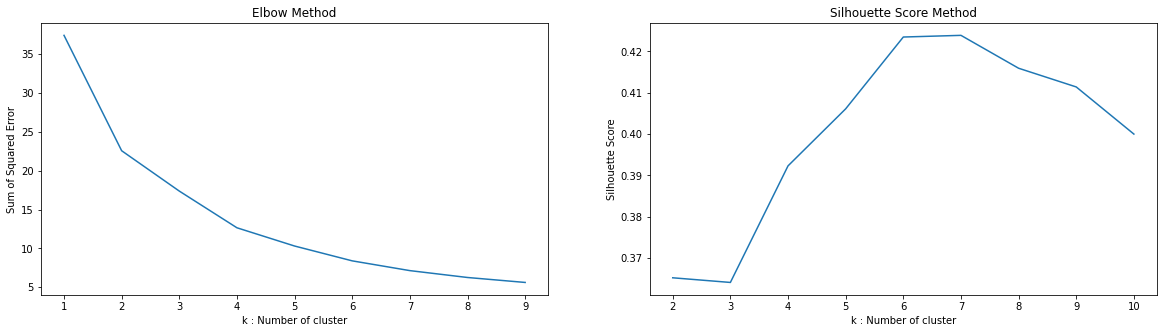

In [42]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m2)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m2)
    labels = kmeans.labels_
    sil.append(silhouette_score(m2, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

- From the results of the above 2 methods, we select :
    - **k : Clusters = 6**

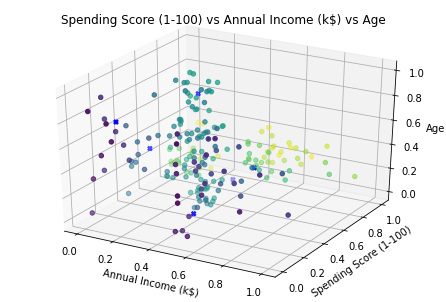

In [43]:
model = KMeans(n_clusters = 6,max_iter = 1000)
model.fit(m2)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_

fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df2['Annual Income (k$)'])
y = np.array(df2['Spending Score (1-100)'])
z = np.array(df2['Age'])
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker = "X", color = 'b')
ax.scatter(x,y,z,c = y)
plt.title('Spending Score (1-100) vs Annual Income (k$) vs Age')
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age')
plt.show();

### <center>Results Table</center>

#### Original Dataset :

|Sr. No.|Feature Combination|Number of Clusters|
|-|-|-|
|1.|Age - Annual Income (k\$)|4|
|2.|Age - Spending Score (1-100)|4|
|3.|Annual Income (k\$) - Spending Score (1-100)|5|
|4.|Age - Annual Income (k\$) - Spending Score (1-100)|6|

#### Normalized Dataset :

|Sr. No.|Feature Combination|Number of Clusters|
|-|-|-|
|1.|Age - Annual Income (k\$)|3|
|2.|Age - Spending Score (1-100)|6|
|3.|Annual Income (k\$) - Spending Score (1-100)|5|
|4.|Age - Annual Income (k\$) - Spending Score (1-100)|6|